# Floquet topological insulators

En esta parte busco entender como construir sistemas Floquet.

Uso el sistema mostrado por I.Fulga en su articulo "Scattering matrix invariants of Floquet topological insulators".

(<Figure size 640x640 with 2 Axes>, <Axes: >)

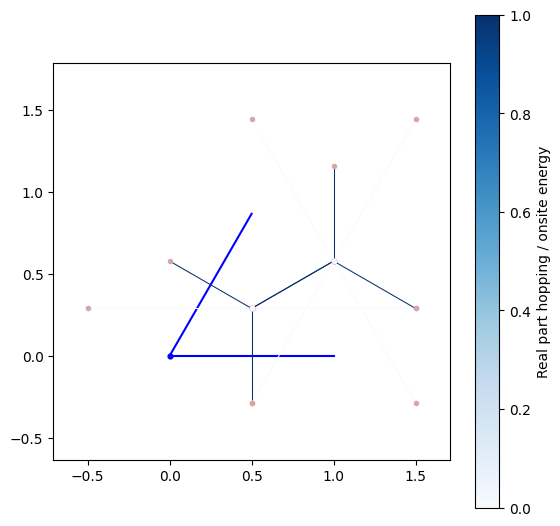

In [1]:
# Kitaev Honeycomb model
from pythtb import *
from pylab import *

def Kitaev_Honeycomb(Jx=1,Jy=1,Jz=1,t2=0):
  a1=np.array([1,0])
  a2=np.array([1/2,sqrt(3)/2])

  lat=np.array([a1,a2])
  orb=[[1/3,1/3],[2/3,2/3]]

  KH=tb_model(2,2,lat,orb)
  KH.set_hop(Jx,0,1,[0,0]) 
  KH.set_hop(Jy,1,0,[0,1])
  KH.set_hop(Jz,1,0,[1,0])

  KH.set_hop(t2,0,0,[1,0])
  KH.set_hop(t2,1,1,[1,-1])
  KH.set_hop(t2,1,1,[0,1])

  return KH

Kitaev_Honeycomb().visualize(0,1)

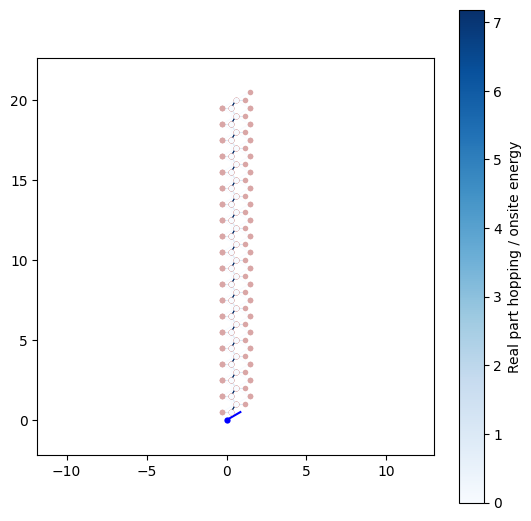

In [83]:
# Contruyo el operador de Floquet para una nanocinta zig-zag siguiendo a I.C.Fulga
W = 20
T = 1
Ju = 0.225*4/T
Js = pi/2*4/T
t2 = 0 #0.03+0.1j

tb1=Kitaev_Honeycomb(t2=t2,Jx=Ju+Js,Jy=Ju,Jz=Ju).cut_piece(W,0)
tb2=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju+Js,Jz=Ju).cut_piece(W,0)
tb3=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju,Jz=Ju+Js).cut_piece(W,0)
tb4=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju,Jz=Ju).cut_piece(W,0)

tb1.visualize(1,0)

k_vec,k_dist,k_node=tb1.k_path([-0.5,0,0.5],501,report=False)

from scipy.linalg import expm

F = [ expm(-1j*T*tb1._gen_ham(k)/4)@expm(-1j*T*tb2._gen_ham(k)/4)@expm(-1j*T*tb3._gen_ham(k)/4)@expm(-1j*T*tb4._gen_ham(k)/4) for k in k_vec]

Ek,evec=[],[]
for i,k in enumerate(k_vec):
    eval,eve = np.linalg.eig(F[i])
    # Nicefy process
    eval=real(1j*log(array(eval))/T) # Quasienergy
    args=eval.argsort()
    eval=eval[args]
    eve = eve.T
    eve = eve[args]
    Ek.append(eval)
    evec.append(eve)
Ek=array(Ek)
evec=array(evec)
IPR=sum(abs(evec)**4,2).T

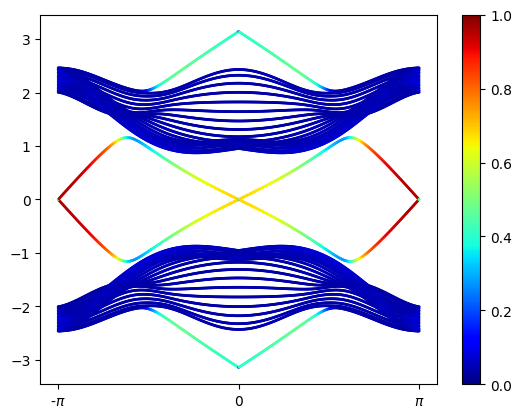

In [84]:
for i,band in enumerate(Ek.T):
    scatter(k_dist,band,s=1,c=IPR[i],vmax=1,vmin=0, cmap="jet")
colorbar()
xticks(k_node,["-$\pi$",0,"$\pi$"]);

Vemos estados localizados en $E=0$ y (para $T>1.7$) en $E=\pm\pi$. Estos ultimos son consecuencia de la existencia de un modo cero en la estructura original el cual surge de romper la simetria de subred en la frontera de la nanocinta zig-zag, no dependen de la simetria particula-hoyo o la reversión temporal, analogo al caso del grafeno.

# Entanglement entropy
Calculo esta entropía en el espacio k de la nanocinta de red hexagonal.

In [85]:
def EEntropy(Ek,evec):
  nF=len(evec[Ek<0]) # Number of states on the Fermi sea
  P=np.sum([evec[l][:,None]*np.conjugate(evec[l]) for l in range(nF)],0)
  C=P[0:nF,0:nF]
  ζ=sort(np.linalg.eigvals(C))[nF//2:nF] # Here we use chiral simmetry
  ζ=np.array([z for z in ζ if(z!=0 and z!=1)]) # We remove the eigenvalues that dont contribute
  SEE=-sum((1-ζ)*np.log(1-ζ)+ζ*np.log(ζ))
  return 2*SEE

def C_Spectre(evec):
  nF=len(evec)//2 # Number of states on the Fermi sea
  P=np.sum([evec[l][:,None]*np.conjugate(evec[l]) for l in range(nF)],0)
  C=P[0:nF,0:nF]
  ζ=list(sort(np.linalg.eigvals(C)))
  return ζ

See = real([ EEntropy(Ek[i],evec[i]) for i,k in enumerate(k_vec)])
C_spec= array([ real(C_Spectre(evec[i])) for i,k in enumerate(k_vec)])

C:\Users\gozu0\AppData\Local\Temp\ipykernel_33052\2703330373.py:2: RuntimeWarning: invalid value encountered in log
  scatter(k_vec,band,s=1,c=-(band*np.log(band)+(1-band)*log(1-band)),vmax=0.15,vmin=-0.15, cmap="jet")
C:\Users\gozu0\AppData\Local\Temp\ipykernel_33052\2703330373.py:2: RuntimeWarning: divide by zero encountered in log
  scatter(k_vec,band,s=1,c=-(band*np.log(band)+(1-band)*log(1-band)),vmax=0.15,vmin=-0.15, cmap="jet")
C:\Users\gozu0\AppData\Local\Temp\ipykernel_33052\2703330373.py:2: RuntimeWarning: invalid value encountered in multiply
  scatter(k_vec,band,s=1,c=-(band*np.log(band)+(1-band)*log(1-band)),vmax=0.15,vmin=-0.15, cmap="jet")


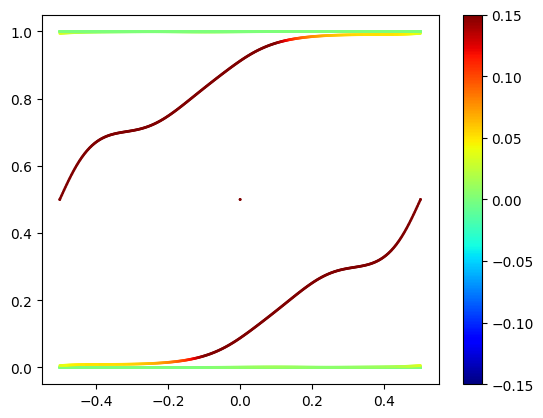

In [86]:
for i,band in enumerate(C_spec.T):
    scatter(k_vec,band,s=1,c=-(band*np.log(band)+(1-band)*log(1-band)),vmax=0.15,vmin=-0.15, cmap="jet")
colorbar();

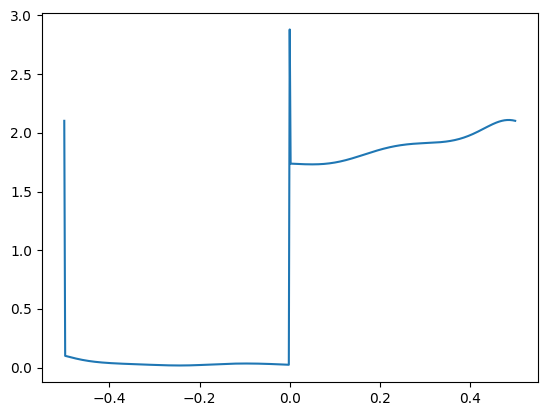

In [87]:
plot(k_vec,See/log(2))

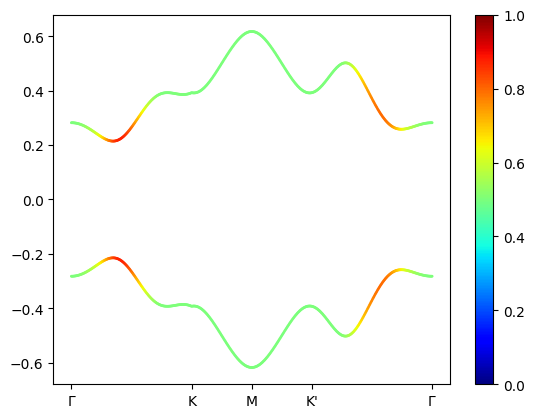

In [91]:
# Contruyo el operador de Floquet para una red 2D del modelo hexagonal de Kitaev 
T = 4
Ju = 0.225#*4/T
Js = pi/2#*4/T
t2 = 0 

tb1=Kitaev_Honeycomb(t2=t2,Jx=Ju+Js,Jy=Ju,Jz=Ju)
tb2=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju+Js,Jz=Ju)
tb3=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju,Jz=Ju+Js)
tb4=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju,Jz=Ju)

k_vec,k_dist,k_node=tb1.k_path([[0,0],[2/3,1/3],[1/2,1/2],[1/3,2/3],[0,0]]
                               ,501,report=False)

from scipy.linalg import expm

F = [ expm(-1j*T*tb1._gen_ham(k)/4)@expm(-1j*T*tb2._gen_ham(k)/4)@expm(-1j*T*tb3._gen_ham(k)/4)@expm(-1j*T*tb4._gen_ham(k)/4) for k in k_vec]

Ek,evec=[],[]
for i,k in enumerate(k_vec):
    eval,eve = np.linalg.eig(F[i])
    # Nicefy process
    eval=real(1j*log(array(eval))/T) # Quasienergy
    args=eval.argsort()
    eval=eval[args]
    eve = eve.T
    eve = eve[args]
    Ek.append(eval)
    evec.append(eve)
Ek=array(Ek)
evec=array(evec)
IPR=sum(abs(evec)**4,2).T

for i,band in enumerate(Ek.T):
    scatter(k_dist,band,s=1,c=IPR[i],vmax=1,vmin=0, cmap="jet")
colorbar()
xticks(k_node,["$\Gamma$","K","M","K'","$\Gamma$"]);

In [92]:
import plotly.graph_objects as go
import pandas as pd
import itertools as itertools


Nk=100
Kx=np.linspace(-1,1,Nk)
Ky=np.linspace(-1,1,Nk)
L_k = np.array(list(itertools.product(Kx, Ky)))

Ek,evec=[],[]
for i,k in enumerate(L_k):
    F = expm(-1j*T*tb1._gen_ham(k)/4)@expm(-1j*T*tb2._gen_ham(k)/4)@expm(-1j*T*tb3._gen_ham(k)/4)@expm(-1j*T*tb4._gen_ham(k)/4)
    eval = np.linalg.eigvals(F)
    eval=sort(real(1j*log(array(eval))/T)) 
    Ek.append(eval)
L_Ek=array(Ek).T

Bands = [L_Ek[i].reshape((Nk,Nk)) for i in range(len(L_Ek))]

fig = go.Figure(data=[go.Surface(z=Bands[0], x= Kx, y=Ky,colorscale='twilight', cmin=-2, cmax=2)]
              +[go.Surface(z=Band, x= Kx, y=Ky, showscale=False, colorscale='twilight', cmin=-2, cmax=2) for Band in Bands[1:]])
fig.update_layout(title='Floquet band structure of driven Kitaev model',autosize=False,
                  width=500, height=500,
                   margin=dict(l=65, r=50, b=65, t=90),
                   scene = {
            "xaxis": {"nticks": 4},
            "yaxis": {"nticks": 4},
            "zaxis": {"nticks": 4},
#            'camera_eye': {"x": 0, "y": -1, "z": 0.5},
            "aspectratio": {"x": 1, "y": 1, "z": 1}
        })
fig.show()

No hay degeneración en las bandas, podemos calcular facilmente el número de Chern.

Primero, deseo visualizar la curvatura de Berry.

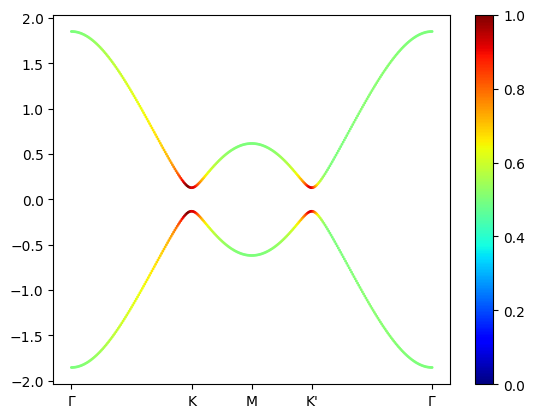

In [93]:
# Contruyo el operador de Floquet para una red 2D del modelo hexagonal de Kitaev 

def Kitaev_Driven(k_vec,Ju,Js,T=1,t2=0,eig_vectors=False):

    tb1=Kitaev_Honeycomb(t2=t2,Jx=Ju+Js,Jy=Ju,Jz=Ju)
    tb2=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju+Js,Jz=Ju)
    tb3=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju,Jz=Ju+Js)
    tb4=Kitaev_Honeycomb(t2=t2,Jx=Ju,Jy=Ju,Jz=Ju)

    from scipy.linalg import expm
    F = [ expm(-1j*T*tb1._gen_ham(k)/4)@expm(-1j*T*tb2._gen_ham(k)/4)@expm(-1j*T*tb3._gen_ham(k)/4)@expm(-1j*T*tb4._gen_ham(k)/4) for k in k_vec]

    norb,nkp = len(F[0]), len(k_vec)
    if(eig_vectors==False):
        ret_eval=np.zeros((norb,nkp),dtype=float)
        for i,k in enumerate(k_vec):
            eval = np.linalg.eigvals(F[i]).T
            ret_eval[:,i]=sort(real(1j*log(array(eval[:]))/T))
        return ret_eval
    else:
        ret_eval=np.zeros((norb,nkp),dtype=float)
        ret_evec=np.zeros((norb,nkp,norb),dtype=complex)
        for i,k in enumerate(k_vec):
            eval,eve = np.linalg.eig(F[i])
            # Nicefy process
            eval=real(1j*log(array(eval))/T) # Quasienergy
            args=eval.argsort()
            eval=eval[args]
            eve = eve.T
            eve = eve[args]
            ret_eval[:,i]=eval[:]
            ret_evec[:,i,:]=eve[:,:]
        return ret_eval,ret_evec


T = 4
Ju = 0.225#*4/T
Js = pi/2#*4/T
t2 = 0 

k_vec,k_dist,k_node=tb1.k_path([[0,0],[2/3,1/3],[1/2,1/2],[1/3,2/3],[0,0]]
                                ,301,report=False)
Ek,evec = Kitaev_Driven(k_vec,Ju,Js,eig_vectors=True)
IPR=sum(abs(evec)**4,2)

for i,band in enumerate(Ek):
    scatter(k_dist,band,s=1,c=IPR[i],vmax=1,vmin=0, cmap="jet")
colorbar()
xticks(k_node,["$\Gamma$","K","M","K'","$\Gamma$"]);

In [52]:
Kitaev_Driven([[1,1]],Ju,Js,T=1,t2=0,eig_vectors=True)

(array([[-1.85309725],
        [ 1.85309725]]),
 array([[[ 0.35355339+0.61237244j,  0.70710678+0.j        ]],
 
        [[ 0.70710678+0.j        , -0.35355339+0.61237244j]]]))

Chern Number= (0.9993081020751858+0j)


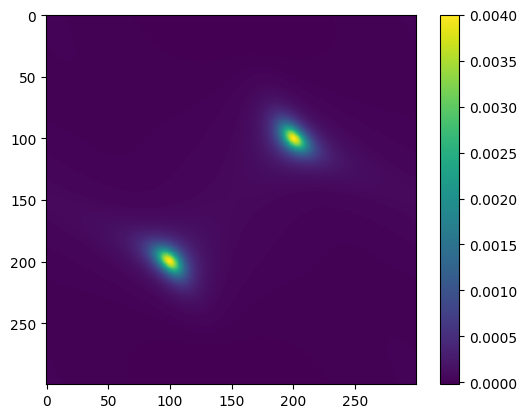

In [98]:
nkpts = 301
Ju = 0.225
Js = pi/2

kmesh = Kitaev_Honeycomb().k_uniform_mesh((nkpts,nkpts))
Ek, U = Kitaev_Driven(kmesh,Ju,Js,eig_vectors=True)

def Curvatura(U0):
    F = zeros( (nkpts-1,nkpts-1), dtype='complex' )
    for n in range(nkpts-1):
        for m in range(nkpts-1):
            F[n,m] = imag(log(\
                vdot(U0[n+0,m+0],U0[n+1,m+0])*\
                vdot(U0[n+1,m+0],U0[n+1,m+1])*\
                vdot(U0[n+1,m+1],U0[n+0,m+1])*\
                vdot(U0[n+0,m+1],U0[n+0,m+0])))
    return F

U0 = U[0].reshape((nkpts,nkpts,2))
F = Curvatura(U0)
print('Chern Number=',sum(F)/(2*pi))
imshow(F.real)
colorbar()